In [1]:
import os
import datetime

import sys

sys.path.append("..")

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from functions import df_security_code, missingValues



mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Data

In [ ]:
# TODO axis o is time dimension

In [2]:
data_train = pd.read_csv('../data/curr_train_data.csv', parse_dates=['Date'],  index_col=[0])
data_test = pd.read_csv('../data/curr_test_data.csv', parse_dates=['Date'],  index_col=[0])
df_train = df_security_code(data_train)
df_test = df_security_code(data_test)
del data_train, data_test

In [3]:
df_train.head(2)

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month,Year,week,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
1994490,20170510_7203,2017-05-10,7203,0.0,0,6162.0,6171.0,6081.0,6081.0,7823700.0,...,5.0,2017.0,19.0,2.988135,1.831109e+12,2.759719e+13,6.635128,27.807907,36.9267,-6.659616
1994491,20170511_7203,2017-05-11,7203,0.0,0,6113.0,6124.0,5975.0,6123.0,13511900.0,...,5.0,2017.0,19.0,2.988135,1.831109e+12,2.759719e+13,6.635128,27.807907,36.9267,-6.659616


In [4]:
df_test.head(2)

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month,Year,week,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
1995585,20211102_7203,2021-11-02,7203,0.0,0,10237.5,10295.0,10152.5,10240.0,3533820.0,...,11.0,2021.0,44.0,3.29452,8.978320e+11,7.935558e+12,11.314037,-60.012132,-70.840800,37.136366
1995586,20211104_7203,2021-11-04,7203,0.0,0,10350.0,10500.0,10137.5,10315.0,7756700.0,...,11.0,2021.0,44.0,3.29452,1.524484e+12,1.548130e+13,9.847262,69.796131,95.087718,-12.964213


- transform date

In [5]:
def transform_date(df):
    date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m.%d')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    day = 24*60*60
    week = 7*day
    month = 30.4167*day
    year = (365.2425)*day

    df['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

    df['Month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    df['Month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))

    df['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [6]:
transform_date(df_train)
transform_date(df_test)

Text(0.5, 1.0, 'Time of Month signal')

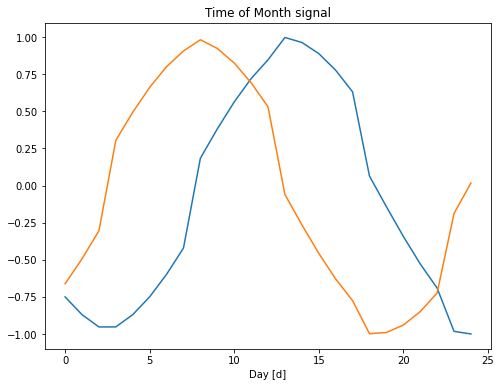

In [7]:
plt.plot(np.array(df_train['Month_sin'])[:25])
plt.plot(np.array(df_train['Month_cos'])[:25])
plt.xlabel('Day [d]')
plt.title('Time of Month signal')

In [8]:
df_train.columns

Index(['RowId', 'SecuritiesCode', 'ExpectedDividend', 'SupervisionFlag',
       'ad_Open', 'ad_High', 'ad_Low', 'ad_Close', 'ad_Volume', 'ad_Target',
       'ad_Close_lag1', 'ad_Close_sma10', 'logprice_ad_Close',
       'trend_ad_Close', 'detrend_ad_Close', 'season_ad_Close',
       'error_ad_Close', 'ad_Open_lag1', 'ad_Open_sma10', 'logprice_ad_Open',
       'trend_ad_Open', 'detrend_ad_Open', 'season_ad_Open', 'error_ad_Open',
       'ad_High_lag1', 'ad_High_sma10', 'logprice_ad_High', 'trend_ad_High',
       'detrend_ad_High', 'season_ad_High', 'error_ad_High', 'ad_Low_lag1',
       'ad_Low_sma10', 'logprice_ad_Low', 'trend_ad_Low', 'detrend_ad_Low',
       'season_ad_Low', 'error_ad_Low', 'ad_Volume_lag1', 'ad_Volume_sma10',
       'RSI', 'Return', 'macd', 'macd_h', 'macd_s', 'Day', 'Month', 'Year',
       'week', 'Volatility_week', 'Profit', 'NetSales', 'margin',
       'win_quarter_growth', 'rev_quarter_growth', 'margin_growth', 'Day_sin',
       'Day_cos', 'Month_sin', 'Month_co

# Preparation for modelling

## - Train Test Split


In [9]:
def split_train_val(df, split=22):
    l_train = len(df)
    df_train =  df[:l_train - split]
    df_val = df[l_train - split : ]
    return df_train, df_val

df_train, df_val = split_train_val(df_train)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1073, 62)
(22, 62)
(22, 62)


In [10]:
missingValues(df_train)

,N_missing,Percentage


In [11]:
missingValues(df_val)

,N_missing,Percentage


In [12]:
missingValues(df_test)

,N_missing,Percentage


## - Scaling

In [43]:
feat_not_to_scale = ['RowId', 'SecuritiesCode']
feat_to_scale = [col for col in df_train.columns if col not in feat_not_to_scale]
len(feat_to_scale)

60

In [50]:
def scaling_df(df, feat_to_scale):
    """    for col in df.columns:
        mean_df = df[col].mean()
        std_df = df[col].std()
        df[col] = (df[col] - mean_df) / std_df"""

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[feat_to_scale])
    
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = feat_to_scale
    return df_scaled
        


In [53]:
df_train_scaled = scaling_df(df_train, feat_to_scale)
df_val_scaled = scaling_df(df_val, feat_to_scale)
df_test_scaled = scaling_df(df_test, feat_to_scale)

In [54]:
print(df_train_scaled.shape)
print(df_val_scaled.shape)
print(df_test_scaled.shape)


(1073, 60)
(22, 60)
(22, 60)


## - Window

### - create window

In [65]:
input_width=22
label_width=1
shift=1
label_columns=['ad_Close']

column_indices = {name: i for i, name in
                           enumerate(df_train_scaled.columns)}

total_window_size = input_width + shift
input_slice = slice(0, input_width) #slice(start, stop, step)

input_indices = np.arange(total_window_size)[input_slice]

label_start = total_window_size - label_width
labels_slice = slice(label_start, None)
label_indices = np.arange(total_window_size)[labels_slice]

label_indices

array([22])

### - split window

In [82]:
def split_window(self, features):
  input_width=22
  label_width=1
  shift=1
  label_columns=['ad_Close']
  input_slice = slice(0, input_width) #slice(start, stop, step)

  column_indices = {name: i for i, name in
                           enumerate(df_train_scaled.columns)}

                           
  inputs = features[:, input_slice, :]
  labels = features[:, labels_slice, :]
  if label_columns is not None:
    labels = tf.stack(
        [labels[:, :, column_indices[name]] for name in label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

In [98]:
data = np.array(df_train_scaled, dtype=np.float32)
targets = np.array(df_val_scaled, dtype=np.float32)
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data, targets, sequence_length=total_window_size, 
    sequence_stride=1,
      shuffle=True,
      batch_size=32,)

#ds = ds.map(split_window)
type(ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [99]:
counter = 0 
for batch in ds:
  counter = counter +1
  print (batch)
  #print(batch)
  print(len(inputs))
  inputs, targets = batch
  #print(len(inputs))
  #assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]



(<tf.Tensor: shape=(22, 23, 60), dtype=float32, numpy=
array([[[-0.09163757,  0.        , -1.2304583 , ..., -0.7183358 ,
          1.1482608 , -0.77397466],
        [-0.09163757,  0.        , -1.2548829 , ..., -0.44987768,
          1.1327273 , -0.79276174],
        [-0.09163757,  0.        , -1.3610767 , ...,  0.41687155,
          1.0841949 , -0.84750175],
        ...,
        [-0.09163757,  0.        , -1.4640847 , ..., -1.2245601 ,
          0.60760385, -1.1830976 ],
        [-0.09163757,  0.        , -1.5628451 , ..., -1.0451461 ,
          0.58502084, -1.1926435 ],
        [-0.09163757,  0.        , -1.5320488 , ..., -0.2840168 ,
          0.51632065, -1.218961  ]],

       [[-0.09163757,  0.        , -1.4640847 , ..., -1.2245601 ,
          0.60760385, -1.1830976 ],
        [-0.09163757,  0.        , -1.5628451 , ..., -1.0451461 ,
          0.58502084, -1.1926435 ],
        [-0.09163757,  0.        , -1.5320488 , ..., -0.2840168 ,
          0.51632065, -1.218961  ],
        ...,

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_scaled, val_df=val_scaled, test_df=test_scaled,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    #self.example = 

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
train_scaled.shape

In [ ]:
w1 = WindowGenerator(input_width=22, label_width=1, shift=1,
                     label_columns=['ad_Close'])
w1

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
example_window = tf.stack([np.array(train_scaled[:w1.total_window_size]),
                           np.array(train_scaled[100:100+w1.total_window_size]),
                           np.array(train_scaled[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
type(example_inputs)

In [ ]:
example_labels

In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='ad_Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
w1.plot()

In [ ]:
w1.plot(plot_col='ad_Target')

- ## create dataset

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

## - train , val , test

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

## - single step models:
predict a single features value 1 time step into future

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['ad_Close'])
single_step_window

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

- Baseline

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=w1.column_indices['ad_Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
#val_performance['Baseline'] = baseline.evaluate(w1.val_df)
#performance['Baseline'] = baseline.evaluate(w1.test_df, verbose=0)

In [ ]:
single_step_window.plot(baseline)

In [ ]:
wide_window = WindowGenerator(
    input_width=22, label_width=22, shift=1,
    label_columns=['ad_Close'])

wide_window

In [ ]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(baseline)

## - linear

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, wide_window)

#val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(linear)

In [ ]:
plt.bar(x = range(len(train_scaled.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_scaled.columns)))
_ = axis.set_xticklabels(train_scaled.columns, rotation=90)

In [ ]:

#val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

In [ ]:
performance

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = linear.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()